In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Function to load and process CSV data
def load_model_data(file_path):
    df = pd.read_csv(file_path)
    # Clean column names and handle possible inconsistencies
    df.columns = [col.strip() for col in df.columns]
    return df

# Load data from all models
gpt4o_data = load_model_data('graph_benchmarking_GPT4o.csv')
deepseek_data = load_model_data('graph_benchmarking_DeepSeekv3.csv')
gemini_data = load_model_data('graph_benchmarking_geminiflash2.0.csv')
deepthink_data = load_model_data('graph_benchmarking_DeepThinkR1.csv')

# Display sample from each dataset to understand structure
print("GPT-4o sample:")
display(gpt4o_data.head(2))

GPT-4o sample:


,graph_id,prompt,true_max_degree,true_connected,true_bipartite,true_hamiltonian_cycle,true_clique_size,llm_max_degree,llm_connected,llm_bipartite,llm_hamiltonian_cycle,llm_clique_size
0,0,You are given an undirected graph with 14 vert...,12,True,False,True,7,15,True,False,True,5
1,1,You are given an undirected graph with 14 vert...,13,True,False,True,8,13,True,False,True,5


In [29]:
# Add after loading the data in the first cell

# Print column names to identify the correct names
print("\nGPT-4o DataFrame Columns:")
print(gpt4o_data.columns.tolist())


GPT-4o DataFrame Columns:
['graph_id', 'prompt', 'true_max_degree', 'true_connected', 'true_bipartite', 'true_hamiltonian_cycle', 'true_clique_size', 'llm_max_degree', 'llm_connected', 'llm_bipartite', 'llm_hamiltonian_cycle', 'llm_clique_size']


In [30]:
# Function to compute accuracy for boolean parameters
def compute_boolean_accuracy(df, param_column, true_column):
    """Compute accuracy for boolean parameters (e.g., Connectivity, Bipartite)"""
    df[f'{param_column}_correct'] = df[param_column] == df[true_column]
    accuracy = df[f'{param_column}_correct'].mean()
    return accuracy

# Function to compute accuracy and error for integer parameters
def compute_integer_metrics(df, param_column, true_column):
    """Compute accuracy and error for integer parameters (e.g., Max Degree, Clique Size)"""
    df[f'{param_column}_correct'] = df[param_column] == df[true_column]
    accuracy = df[f'{param_column}_correct'].mean()
    
    # Calculate average error (absolute difference)
    df[f'{param_column}_error'] = abs(df[param_column].astype(float) - df[true_column].astype(float))
    avg_error = df[f'{param_column}_error'].mean()
    
    return accuracy, avg_error

# Replace the calculate_model_metrics function
def calculate_model_metrics(df):
    metrics = {}
    
    # First determine the actual column names by checking what exists
    # For connected property
    conn_col = next((col for col in df.columns if 'connect' in col.lower() and not 'true' in col.lower()), None)
    true_conn_col = next((col for col in df.columns if 'connect' in col.lower() and 'true' in col.lower()), None)
    
    # For bipartite property
    bip_col = next((col for col in df.columns if 'bipartite' in col.lower() and not 'true' in col.lower()), None)
    true_bip_col = next((col for col in df.columns if 'bipartite' in col.lower() and 'true' in col.lower()), None)
    
    # For hamiltonian property
    ham_col = next((col for col in df.columns if 'hamilton' in col.lower() and not 'true' in col.lower()), None)
    true_ham_col = next((col for col in df.columns if 'hamilton' in col.lower() and 'true' in col.lower()), None)
    
    # For max degree
    max_deg_col = next((col for col in df.columns if 'degree' in col.lower() and not 'true' in col.lower()), None)
    true_max_deg_col = next((col for col in df.columns if 'degree' in col.lower() and 'true' in col.lower()), None)
    
    # For max clique
    clique_col = next((col for col in df.columns if 'clique' in col.lower() and not 'true' in col.lower()), None)
    true_clique_col = next((col for col in df.columns if 'clique' in col.lower() and 'true' in col.lower()), None)
    
    print(f"Found columns:\nConnected: {conn_col} -> {true_conn_col}")
    print(f"Bipartite: {bip_col} -> {true_bip_col}")
    print(f"Hamiltonian: {ham_col} -> {true_ham_col}")
    print(f"Max Degree: {max_deg_col} -> {true_max_deg_col}")
    print(f"Max Clique: {clique_col} -> {true_clique_col}")
    
    # Boolean parameters
    if conn_col and true_conn_col:
        metrics['Conn_accuracy'] = compute_boolean_accuracy(df, conn_col, true_conn_col)
    else:
        metrics['Conn_accuracy'] = float('nan')
        
    if bip_col and true_bip_col:
        metrics['Bip_accuracy'] = compute_boolean_accuracy(df, bip_col, true_bip_col)
    else:
        metrics['Bip_accuracy'] = float('nan')
        
    if ham_col and true_ham_col:
        metrics['HamC_accuracy'] = compute_boolean_accuracy(df, ham_col, true_ham_col)
    else:
        metrics['HamC_accuracy'] = float('nan')
    
    # Integer parameters
    if max_deg_col and true_max_deg_col:
        metrics['MaxDeg_accuracy'], metrics['MaxDeg_error'] = compute_integer_metrics(df, max_deg_col, true_max_deg_col)
    else:
        metrics['MaxDeg_accuracy'] = float('nan')
        metrics['MaxDeg_error'] = float('nan')
        
    if clique_col and true_clique_col:
        metrics['Clique_accuracy'], metrics['Clique_error'] = compute_integer_metrics(df, clique_col, true_clique_col)
    else:
        metrics['Clique_accuracy'] = float('nan')
        metrics['Clique_error'] = float('nan')
    
    # Calculate "Exact-5" - proportion of examples where all 5 parameters are correct
    # We need to handle the case where some column names weren't found
    all_correct_cols = []
    
    if conn_col and true_conn_col:
        all_correct_cols.append(f'{conn_col}_correct')
    if bip_col and true_bip_col:
        all_correct_cols.append(f'{bip_col}_correct')
    if ham_col and true_ham_col:
        all_correct_cols.append(f'{ham_col}_correct')
    if max_deg_col and true_max_deg_col:
        all_correct_cols.append(f'{max_deg_col}_correct')
    if clique_col and true_clique_col:
        all_correct_cols.append(f'{clique_col}_correct')
    
    if all_correct_cols:
        df['all_correct'] = df[all_correct_cols].all(axis=1)
        metrics['Exact-5'] = df['all_correct'].mean()
    else:
        metrics['Exact-5'] = float('nan')
    
    return metrics

# Calculate metrics for each model
gpt4o_metrics = calculate_model_metrics(gpt4o_data)
deepseek_metrics = calculate_model_metrics(deepseek_data)
gemini_metrics = calculate_model_metrics(gemini_data)
deepthink_metrics = calculate_model_metrics(deepthink_data)

Found columns:
Connected: llm_connected -> true_connected
Bipartite: llm_bipartite -> true_bipartite
Hamiltonian: llm_hamiltonian_cycle -> true_hamiltonian_cycle
Max Degree: llm_max_degree -> true_max_degree
Max Clique: llm_clique_size -> true_clique_size
Found columns:
Connected: llm_connected -> true_connected
Bipartite: llm_bipartite -> true_bipartite
Hamiltonian: llm_hamiltonian_cycle -> true_hamiltonian_cycle
Max Degree: llm_max_degree -> true_max_degree
Max Clique: llm_clique_size -> true_clique_size
Found columns:
Connected: llm_connected -> true_connected
Bipartite: llm_bipartite -> true_bipartite
Hamiltonian: llm_hamiltonian_cycle -> true_hamiltonian_cycle
Max Degree: llm_max_degree -> true_max_degree
Max Clique: llm_clique_size -> true_clique_size
Found columns:
Connected: llm_connected -> true_connected
Bipartite: llm_bipartite -> true_bipartite
Hamiltonian: llm_hamiltonian_cycle -> true_hamiltonian_cycle
Max Degree: llm_max_degree -> true_max_degree
Max Clique: llm_clique_s

In [31]:
# Create accuracy table
def create_accuracy_table():
    models = ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
    metrics_dicts = [gpt4o_metrics, deepseek_metrics, gemini_metrics, deepthink_metrics]
    
    # Parameters to display in the table
    params = ['MaxDeg', 'Conn', 'Bip', 'HamC', 'Clique', 'Exact-5']
    
    # Create DataFrame for the accuracy table
    table_data = []
    for model, metrics in zip(models, metrics_dicts):
        row = {'Model': model}
        row['MaxDeg'] = metrics['MaxDeg_accuracy']
        row['Conn'] = metrics['Conn_accuracy']
        row['Bip'] = metrics['Bip_accuracy']
        row['HamC'] = metrics['HamC_accuracy']
        row['Clique'] = metrics['Clique_accuracy']
        row['Exact-5'] = metrics['Exact-5']
        table_data.append(row)
    
    accuracy_table = pd.DataFrame(table_data)
    return accuracy_table

# Create and display the accuracy table
accuracy_table = create_accuracy_table()
display(accuracy_table)

# Create a more detailed table that includes error metrics for integer parameters
def create_detailed_metrics_table():
    models = ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
    metrics_dicts = [gpt4o_metrics, deepseek_metrics, gemini_metrics, deepthink_metrics]
    
    # Create DataFrame for the detailed metrics table
    table_data = []
    for model, metrics in zip(models, metrics_dicts):
        row = {'Model': model}
        
        # Add accuracy metrics
        for param in ['MaxDeg', 'Conn', 'Bip', 'HamC', 'Clique']:
            row[f'{param}_acc'] = metrics[f'{param}_accuracy']
        
        # Add error metrics for integer parameters
        for param in ['MaxDeg', 'Clique']:
            row[f'{param}_err'] = metrics[f'{param}_error']
        
        row['Exact-5'] = metrics['Exact-5']
        table_data.append(row)
    
    detailed_table = pd.DataFrame(table_data)
    return detailed_table

# Create and display the detailed metrics table
detailed_metrics_table = create_detailed_metrics_table()
display(detailed_metrics_table)

,Model,MaxDeg,Conn,Bip,HamC,Clique,Exact-5
0,GPT-4o,0.61,0.98,0.95,0.92,0.59,0.43
1,DeepSeek,0.69,0.92,0.92,0.90,0.53,0.34
2,Gemini Flash,0.60,0.94,0.89,0.91,0.55,0.38
3,DeepThink,0.91,0.96,0.97,0.96,0.90,0.83


,Model,MaxDeg_acc,Conn_acc,Bip_acc,HamC_acc,Clique_acc,MaxDeg_err,Clique_err,Exact-5
0,GPT-4o,0.61,0.98,0.95,0.92,0.59,0.68,1.31,0.43
1,DeepSeek,0.69,0.92,0.92,0.90,0.53,0.61,1.22,0.34
2,Gemini Flash,0.60,0.94,0.89,0.91,0.55,0.70,1.33,0.38
3,DeepThink,0.91,0.96,0.97,0.96,0.90,0.15,0.20,0.83


In [32]:
def extract_graph_properties(df):
    # Check if 'prompt' column exists
    if 'prompt' not in df.columns:
        print("Warning: 'prompt' column not found in dataframe")
        df['num_vertices'] = 10  # Default value
        df['num_edges'] = 20     # Default value
        return df

    # Extract number of vertices using more flexible patterns
    vertices_pattern = r"graph with (\d+) vert|(\d+)[- ]vertices|(\d+)[- ]nodes"
    vertices_extracted = df['prompt'].str.extract(vertices_pattern)
    
    # Combine results from different capture groups
    if vertices_extracted.isna().all().all():
        print("Warning: Failed to extract vertices from prompts")
        df['num_vertices'] = 10  # Default value
    else:
        # Combine results from different capture groups
        df['num_vertices'] = vertices_extracted.apply(lambda x: next((int(val) for val in x if pd.notna(val)), 10), axis=1)

    # Try multiple patterns for edge extraction
    edge_patterns = [
        r"and (\d+) edge",  # Original pattern
        r"(\d+) edges",     # Just the number followed by "edges"
        r"with (\d+) edge", # Alternative phrasing
        r"E = (\d+)",       # Mathematical notation
        r"graph has (\d+) edge"  # Another common phrasing
    ]
    
    # Try each pattern until successful
    for pattern in edge_patterns:
        edges_extracted = df['prompt'].str.extract(pattern)
        if not edges_extracted.iloc[:, 0].isna().all():
            df['num_edges'] = edges_extracted.iloc[:, 0].fillna(0).astype(int)
            print(f"Successfully extracted edges using pattern: '{pattern}'")
            break
    else:
        # If we've tried all patterns and still failed
        print("Warning: Could not extract edges with any pattern, examining sample prompts...")
        
        # Print sample prompts for diagnosis
        if len(df) > 0:
            print("Sample prompts:")
            for i in range(min(3, len(df))):
                sample = df['prompt'].iloc[i]
                if isinstance(sample, str):
                    print(f"  {sample[:100]}...")
        
        # Count edge representations in adjacency list format (e.g., "1-2, 2-3")
        df['num_edges'] = df['prompt'].apply(
            lambda x: len(re.findall(r'\d+-\d+', str(x))) if isinstance(x, str) else 0
        )
        
        # If still zero, use a reasonable default based on number of vertices
        if df['num_edges'].max() == 0:
            print("Setting default edge counts based on vertex counts...")
            # Use approximately 30% of possible edges in a complete graph
            df['num_edges'] = df['num_vertices'].apply(lambda n: max(1, int(0.3 * n * (n-1) / 2)))

    # Debug log
    print(f"Extracted properties: vertices range {df['num_vertices'].min()}-{df['num_vertices'].max()}, "
          f"edges range {df['num_edges'].min()}-{df['num_edges'].max()}")

    return df

# Function to analyze performance by number of vertices with robust error handling
def analyze_by_vertices(dataframes, model_names):
    plt.figure(figsize=(12, 8))
    legend_items = []
    
    for df, model_name in zip(dataframes, model_names):
        # Verify required columns exist
        if 'num_vertices' not in df.columns:
            print(f"Warning: 'num_vertices' column not found in {model_name} data")
            continue
        
        if 'all_correct' not in df.columns:
            print(f"Warning: 'all_correct' column not found in {model_name} data")
            continue
        
        # Group by number of vertices and calculate average correctness
        try:
            vertices_analysis = df.groupby('num_vertices')['all_correct'].mean()
            
            if not vertices_analysis.empty:
                line, = plt.plot(vertices_analysis.index, vertices_analysis.values, marker='o')
                legend_items.append((line, model_name))
            else:
                print(f"Warning: No valid data points for {model_name}")
        except Exception as e:
            print(f"Error analyzing {model_name} by vertices: {e}")
    
    plt.xlabel('Number of Vertices')
    plt.ylabel('Proportion All Correct')
    plt.title('Model Performance by Graph Size')
    
    # Only add legend if we have items
    if legend_items:
        lines, labels = zip(*legend_items)
        plt.legend(lines, labels)
    
    plt.grid(True, alpha=0.3)
    plt.show()

# Function to analyze performance by average degree with robust error handling
def analyze_by_avg_degree(dataframes, model_names):
    plt.figure(figsize=(12, 8))
    legend_items = []
    
    for df, model_name in zip(dataframes, model_names):
        # Verify required columns exist
        missing_cols = []
        for col in ['num_edges', 'num_vertices', 'all_correct']:
            if col not in df.columns:
                missing_cols.append(col)
        
        if missing_cols:
            print(f"Warning: Missing columns for {model_name}: {', '.join(missing_cols)}")
            continue
        
        try:
            # Calculate average degree for each graph
            df['avg_degree'] = 2 * df['num_edges'] / df['num_vertices']
            
            # Handle any potential division by zero
            df['avg_degree'] = df['avg_degree'].replace([np.inf, -np.inf], np.nan).fillna(0)
            
            # Create bins, handling edge cases where all values are the same
            if df['avg_degree'].nunique() < 2:
                print(f"Warning: Not enough unique values for binning in {model_name}")
                bins = [df['avg_degree'].min() - 0.5, df['avg_degree'].min() + 0.5]
            else:
                bins = min(10, df['avg_degree'].nunique())
            
            # Bin the average degree into ranges
            df['degree_bin'] = pd.cut(df['avg_degree'], bins=bins)
            
            # Group by degree bins and calculate average correctness
            degree_analysis = df.groupby('degree_bin')['all_correct'].mean().reset_index()
            
            # Skip if empty
            if degree_analysis.empty:
                print(f"Warning: No valid data points for {model_name}")
                continue
                
            # Use the midpoint of each bin for plotting
            midpoints = [(bin.left + bin.right)/2 for bin in degree_analysis['degree_bin']]
            line, = plt.plot(midpoints, degree_analysis['all_correct'], marker='o')
            legend_items.append((line, model_name))
            
        except Exception as e:
            print(f"Error analyzing {model_name} by degree: {e}")
    
    plt.xlabel('Average Degree')
    plt.ylabel('Proportion All Correct')
    plt.title('Model Performance by Graph Density')
    
    # Only add legend if we have items
    if legend_items:
        lines, labels = zip(*legend_items)
        plt.legend(lines, labels)
    
    plt.grid(True, alpha=0.3)
    plt.show()

print("Functions defined successfully. Run analysis functions separately.")

Functions defined successfully. Run analysis functions separately.


In [33]:
# Process each dataframe to extract graph properties before analysis
print("Extracting graph properties from each dataset...")
gpt4o_data = extract_graph_properties(gpt4o_data)
deepseek_data = extract_graph_properties(deepseek_data)
gemini_data = extract_graph_properties(gemini_data)
deepthink_data = extract_graph_properties(deepthink_data)

Extracting graph properties from each dataset...
Sample prompts:
  You are given an undirected graph with 14 vertices labeled 0 through 13.
 
 The edges of the graph a...
  You are given an undirected graph with 14 vertices labeled 0 through 13.
 
 The edges of the graph a...
  You are given an undirected graph with 13 vertices labeled 0 through 12.
 
 The edges of the graph a...
Setting default edge counts based on vertex counts...
Extracted properties: vertices range 1-20, edges range 1-57
Sample prompts:
  You are given an undirected graph with 14 vertices labeled 0 through 13.
 
 The edges of the graph a...
  You are given an undirected graph with 14 vertices labeled 0 through 13.
 
 The edges of the graph a...
  You are given an undirected graph with 13 vertices labeled 0 through 12.
 
 The edges of the graph a...
Setting default edge counts based on vertex counts...
Extracted properties: vertices range 1-20, edges range 1-57
Sample prompts:
  You are given an undirected graph wit

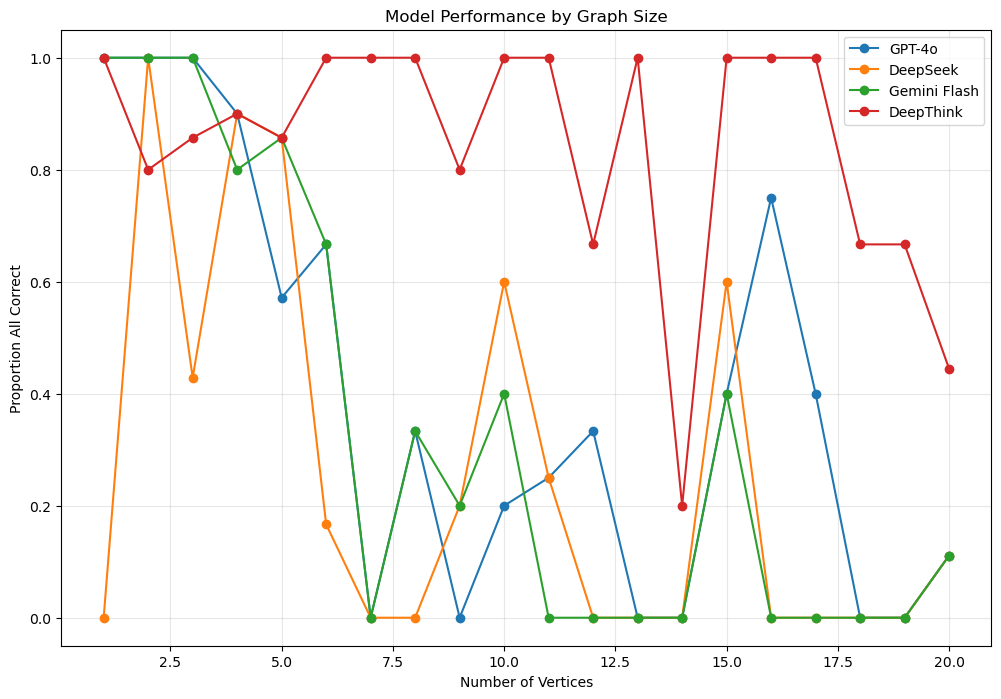

/var/folders/d_/gtzczdxj3nv99_czhtdz7syr0000gn/T/ipykernel_72920/2738246603.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  degree_analysis = df.groupby('degree_bin')['all_correct'].mean().reset_index()
/var/folders/d_/gtzczdxj3nv99_czhtdz7syr0000gn/T/ipykernel_72920/2738246603.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  degree_analysis = df.groupby('degree_bin')['all_correct'].mean().reset_index()
/var/folders/d_/gtzczdxj3nv99_czhtdz7syr0000gn/T/ipykernel_72920/2738246603.py:139: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pand

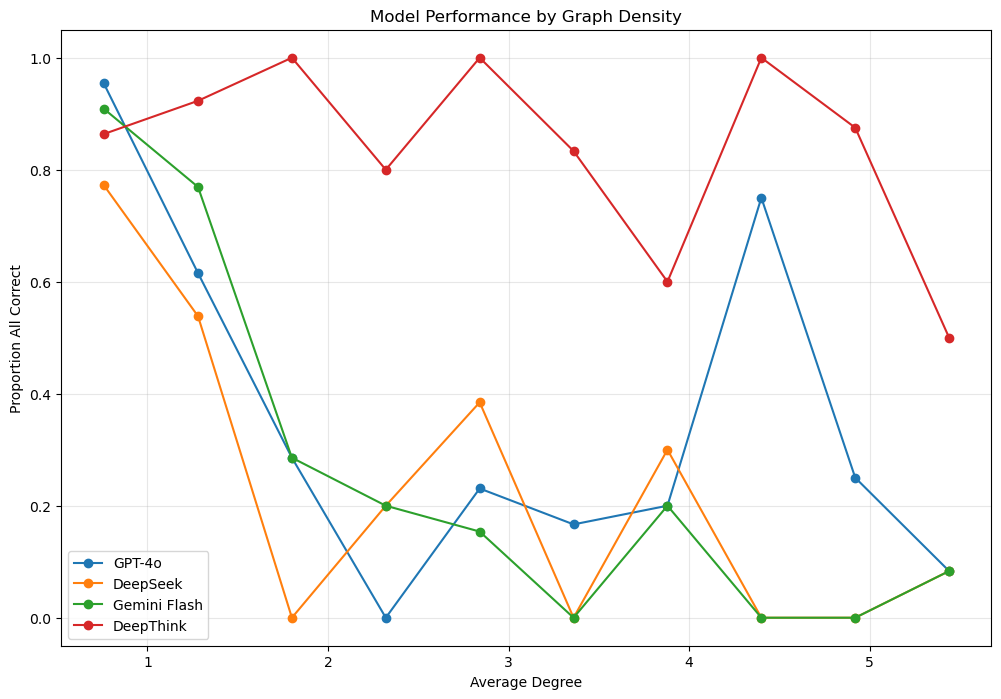

In [35]:
# Run the analyses in a separate cell
analyze_by_vertices(
    [gpt4o_data, deepseek_data, gemini_data, deepthink_data],
    ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
)

analyze_by_avg_degree(
    [gpt4o_data, deepseek_data, gemini_data, deepthink_data],
    ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
)

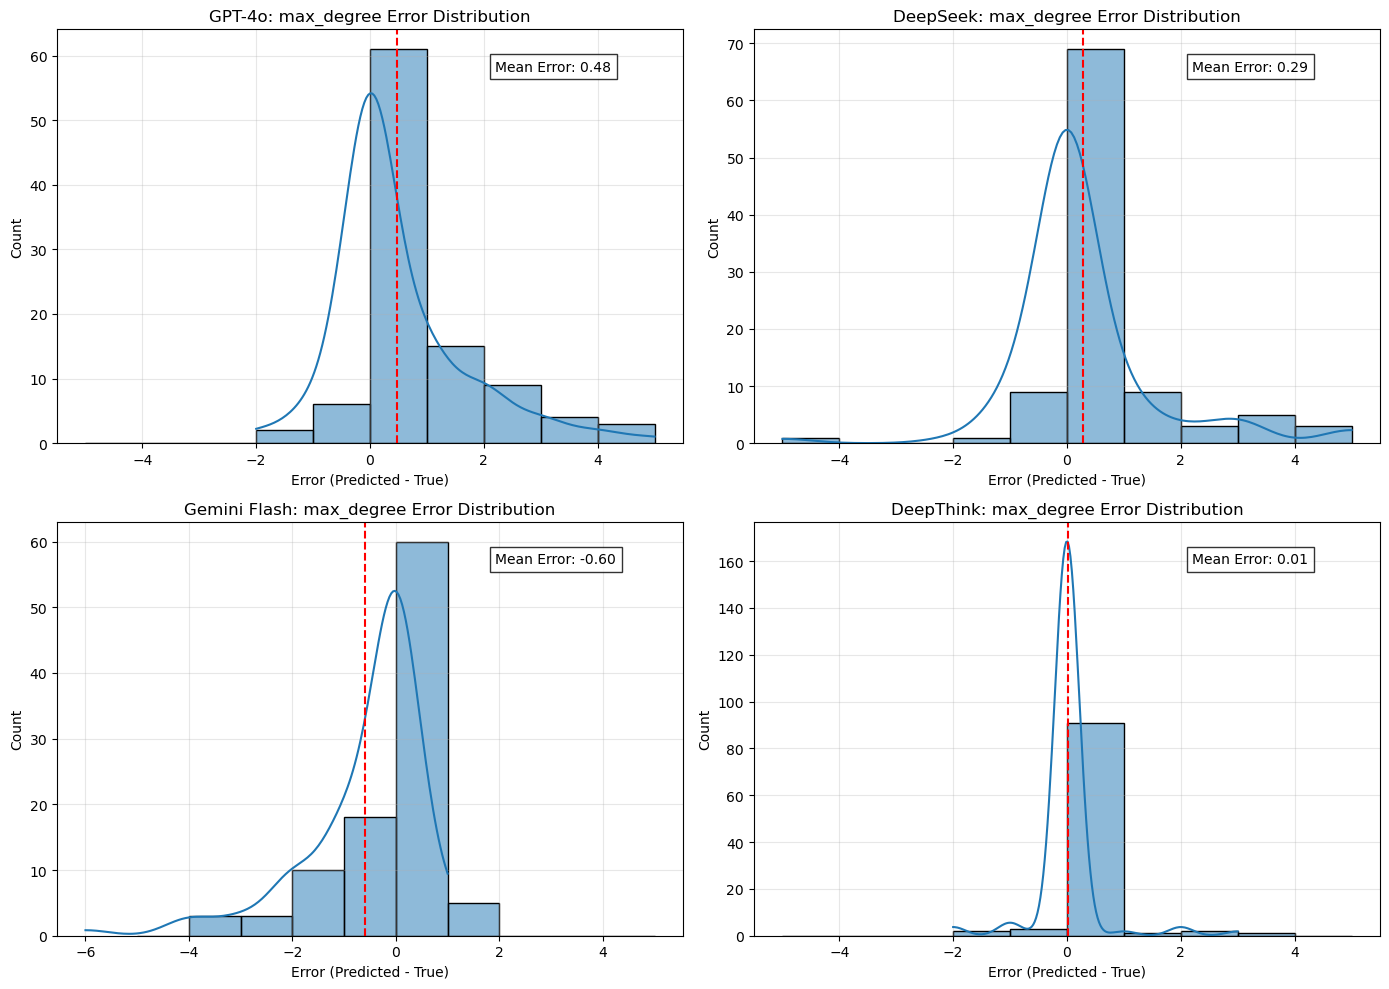

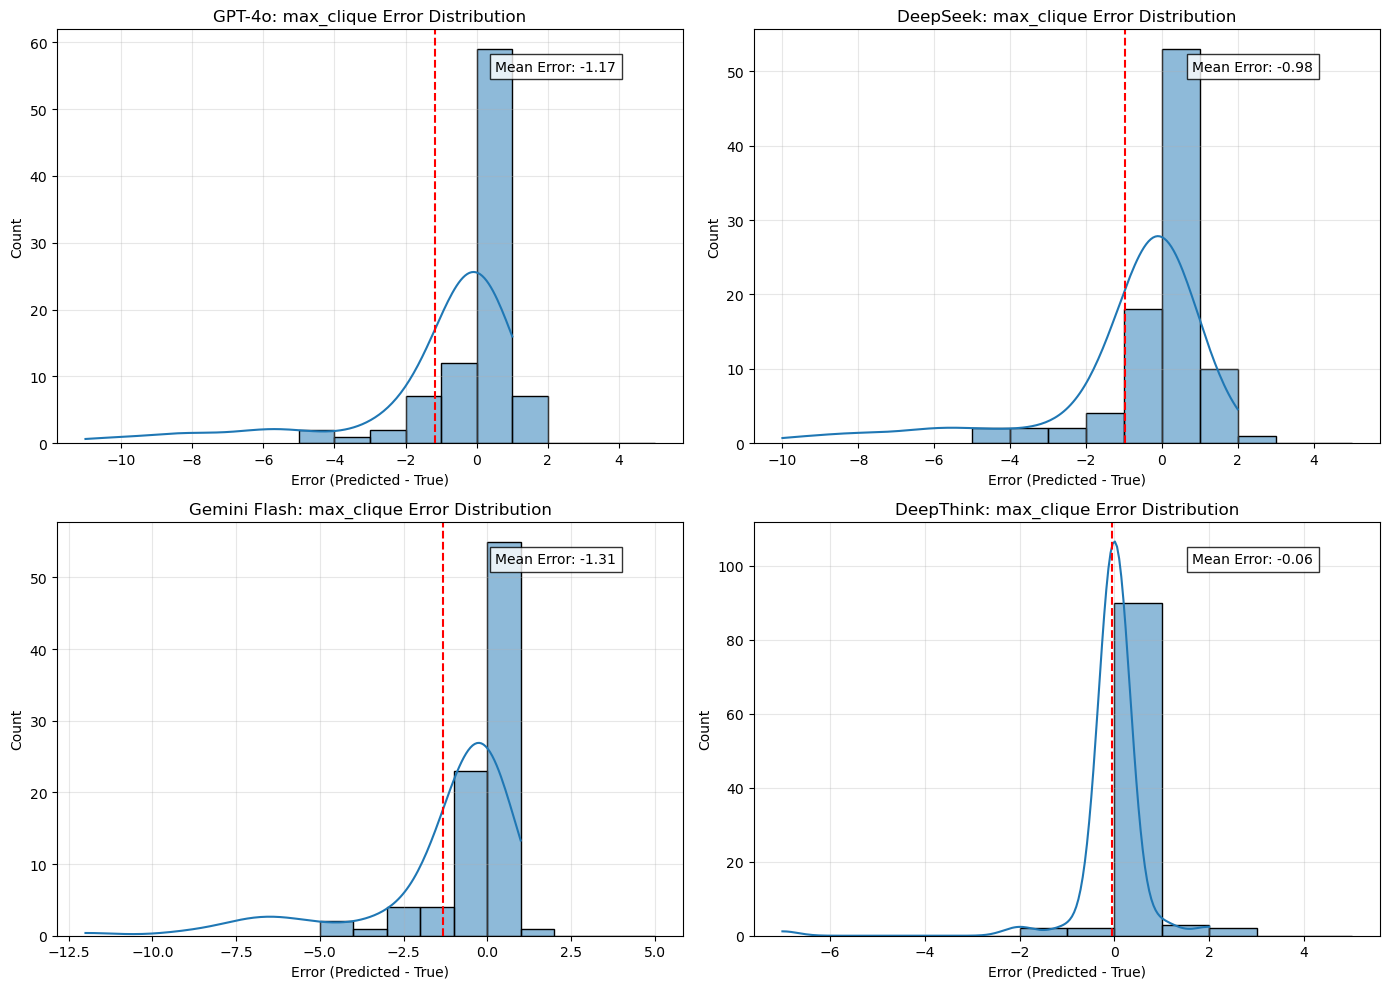

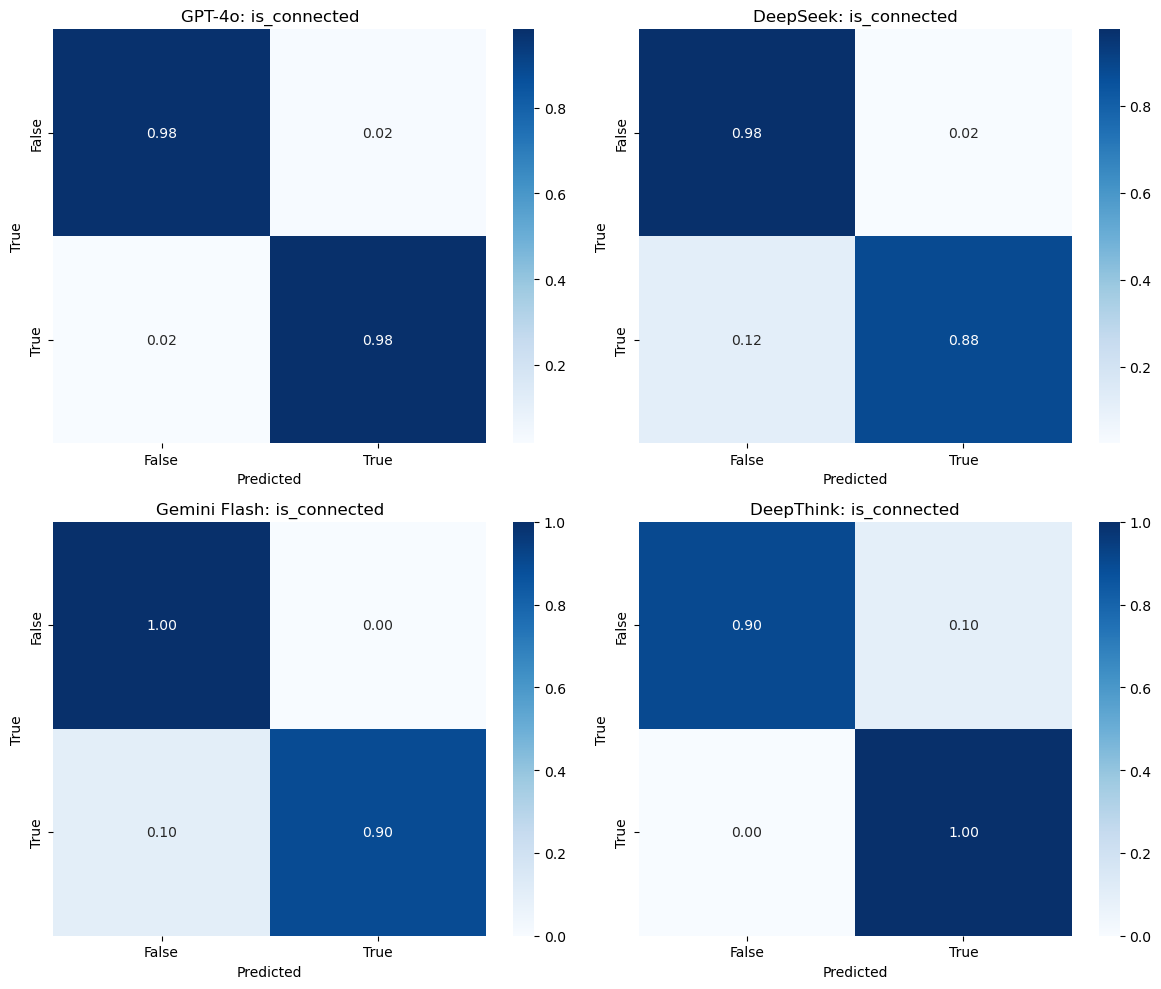


GPT-4o - is_connected error analysis:
Average edge density in error cases: 0.299
Average edge density in correct cases: inf

DeepSeek - is_connected error analysis:
Average edge density in error cases: 0.299
Average edge density in correct cases: inf

Gemini Flash - is_connected error analysis:
Average edge density in error cases: 0.296
Average edge density in correct cases: inf

DeepThink - is_connected error analysis:
Average edge density in error cases: 0.450
Average edge density in correct cases: inf


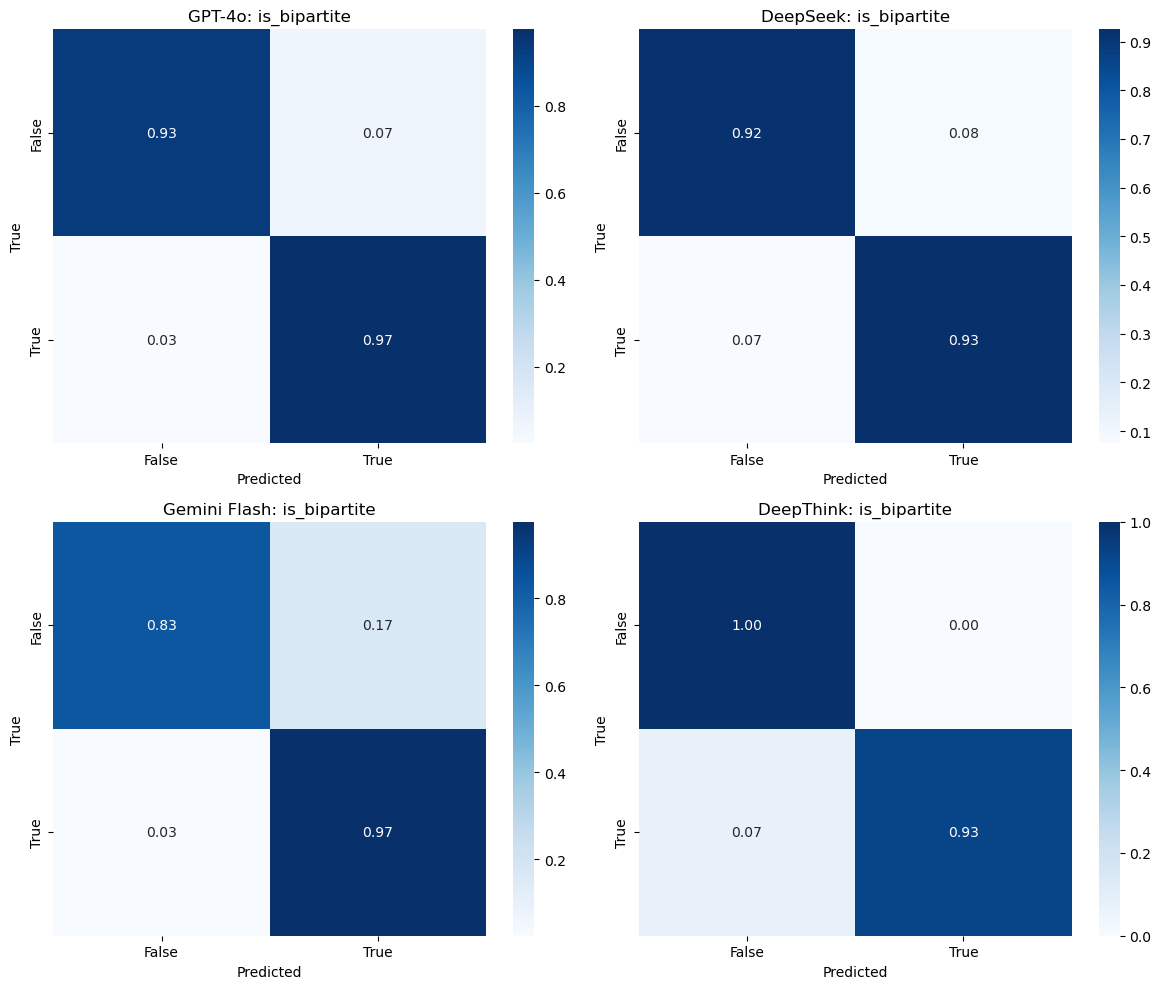

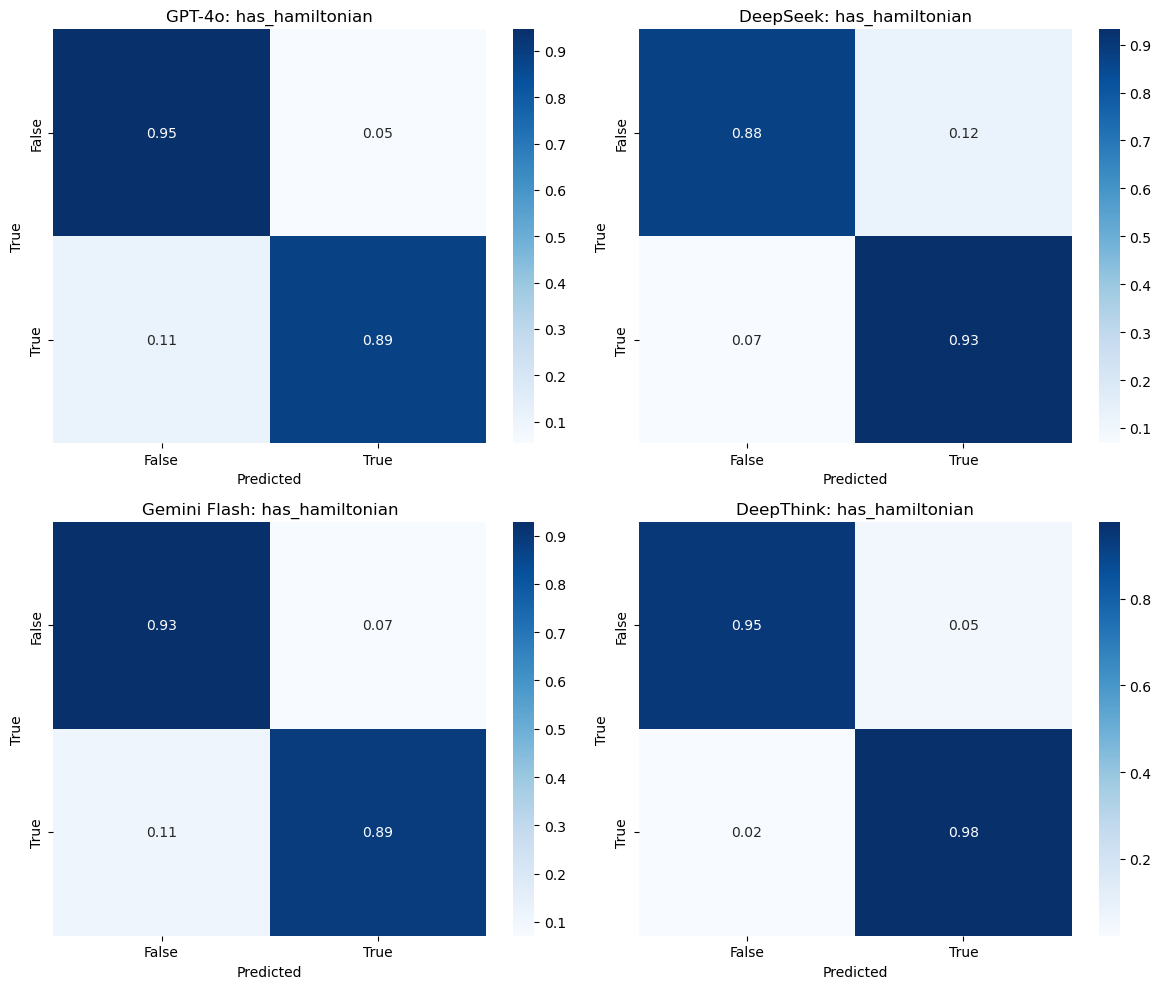

Accuracy by computational complexity:

GPT-4o:
  MaxDeg: 0.610
  Conn: 0.980
  Bip: 0.950
  HamC: 0.920
  Clique: 0.590
  Follows theoretical complexity ordering: False
  Correlation with complexity rank: -0.082

DeepSeek:
  MaxDeg: 0.690
  Conn: 0.920
  Bip: 0.920
  HamC: 0.900
  Clique: 0.530
  Follows theoretical complexity ordering: False
  Correlation with complexity rank: -0.306

Gemini Flash:
  MaxDeg: 0.600
  Conn: 0.940
  Bip: 0.890
  HamC: 0.910
  Clique: 0.550
  Follows theoretical complexity ordering: False
  Correlation with complexity rank: -0.110

DeepThink:
  MaxDeg: 0.910
  Conn: 0.960
  Bip: 0.970
  HamC: 0.960
  Clique: 0.900
  Follows theoretical complexity ordering: False
  Correlation with complexity rank: -0.098


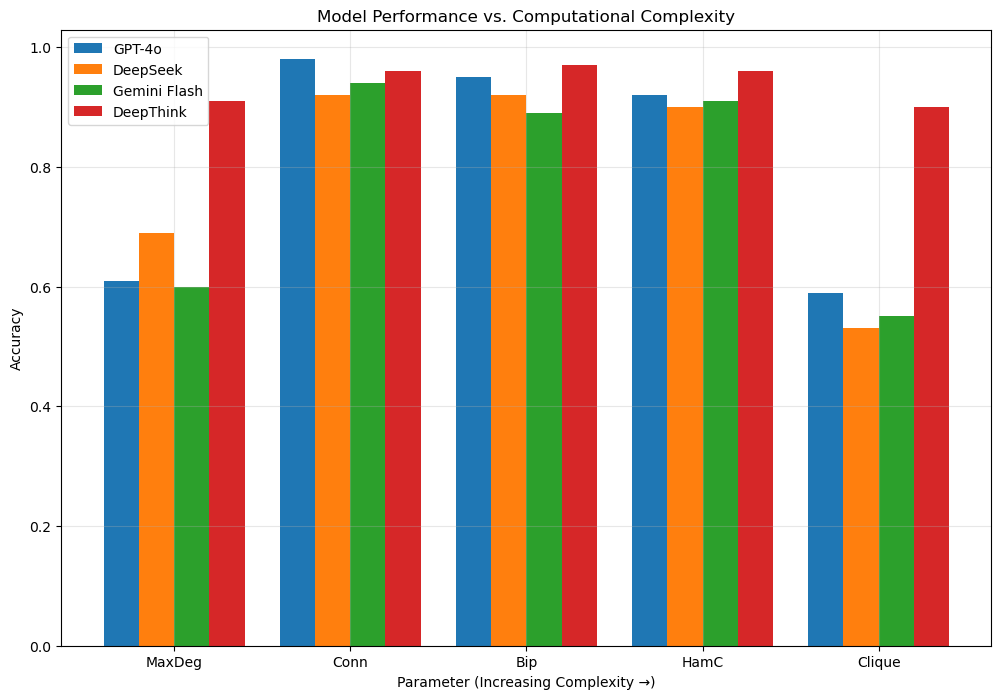

In [36]:
# Function to analyze error patterns for each parameter
def error_analysis():
    models = [gpt4o_data, deepseek_data, gemini_data, deepthink_data]
    model_names = ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
    
    # Find the actual column names for each model's dataframe
    model_columns = []
    for df in models:
        columns = {}
        # For max degree
        columns['max_degree'] = next((col for col in df.columns if 'degree' in col.lower() and not 'true' in col.lower()), None)
        columns['true_max_degree'] = next((col for col in df.columns if 'degree' in col.lower() and 'true' in col.lower()), None)
        
        # For max clique
        columns['max_clique'] = next((col for col in df.columns if 'clique' in col.lower() and not 'true' in col.lower()), None)
        columns['true_max_clique'] = next((col for col in df.columns if 'clique' in col.lower() and 'true' in col.lower()), None)
        
        # For connected property
        columns['is_connected'] = next((col for col in df.columns if 'connect' in col.lower() and not 'true' in col.lower()), None)
        columns['true_is_connected'] = next((col for col in df.columns if 'connect' in col.lower() and 'true' in col.lower()), None)
        
        # For bipartite property
        columns['is_bipartite'] = next((col for col in df.columns if 'bipartite' in col.lower() and not 'true' in col.lower()), None)
        columns['true_is_bipartite'] = next((col for col in df.columns if 'bipartite' in col.lower() and 'true' in col.lower()), None)
        
        # For hamiltonian property
        columns['has_hamiltonian'] = next((col for col in df.columns if 'hamilton' in col.lower() and not 'true' in col.lower()), None)
        columns['true_has_hamiltonian'] = next((col for col in df.columns if 'hamilton' in col.lower() and 'true' in col.lower()), None)
        
        model_columns.append(columns)
    
    # Integer parameters analysis
    for param_key, true_param_key in [('max_degree', 'true_max_degree'), 
                                     ('max_clique', 'true_max_clique')]:
        plt.figure(figsize=(14, 10))
        
        for i, (df, name, cols) in enumerate(zip(models, model_names, model_columns)):
            param = cols[param_key]
            true_param = cols[true_param_key]
            
            if not param or not true_param:
                print(f"Warning: {param_key} columns not found for {name}")
                continue
                
            plt.subplot(2, 2, i+1)
            
            # Calculate error (predicted - true)
            df[f'{param}_diff'] = df[param].astype(float) - df[true_param].astype(float)
            
            # Create histogram of errors
            sns.histplot(df[f'{param}_diff'], bins=range(-5, 6), kde=True)
            plt.title(f'{name}: {param_key} Error Distribution')
            plt.xlabel('Error (Predicted - True)')
            plt.ylabel('Count')
            plt.grid(True, alpha=0.3)
            
            # Add statistics
            mean_error = df[f'{param}_diff'].mean()
            plt.axvline(mean_error, color='red', linestyle='--')
            plt.text(0.7, 0.9, f'Mean Error: {mean_error:.2f}', 
                     transform=plt.gca().transAxes, 
                     bbox=dict(facecolor='white', alpha=0.8))
            
        plt.tight_layout()
        plt.show()
    
    # Boolean parameters analysis - confusion matrices
    for param_key, true_param_key in [('is_connected', 'true_is_connected'), 
                                     ('is_bipartite', 'true_is_bipartite'),
                                     ('has_hamiltonian', 'true_has_hamiltonian')]:
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for i, (df, name, cols) in enumerate(zip(models, model_names, model_columns)):
            param = cols[param_key]
            true_param = cols[true_param_key]
            
            if not param or not true_param:
                print(f"Warning: {param_key} columns not found for {name}")
                continue
            
            # Create confusion matrix data
            cm = pd.crosstab(df[true_param], df[param], 
                            rownames=['True'], colnames=['Predicted'],
                            normalize='index')
            
            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{name}: {param_key}')
            
        plt.tight_layout()
        plt.show()
        
        # Check for any specific patterns
        for i, (df, name, cols) in enumerate(zip(models, model_names, model_columns)):
            param = cols[param_key]
            true_param = cols[true_param_key]
            
            if not param or not true_param or 'num_edges' not in df.columns or 'num_vertices' not in df.columns:
                continue
                
            # For connected graphs, check if models tend to make errors on sparse graphs
            if param_key == 'is_connected':
                df['edge_density'] = df['num_edges'] / (df['num_vertices'] * (df['num_vertices'] - 1) / 2)
                print(f"\n{name} - {param_key} error analysis:")
                error_cases = df[df[param] != df[true_param]]
                if len(error_cases) > 0:
                    avg_error_density = error_cases['edge_density'].mean()
                    avg_correct_density = df[df[param] == df[true_param]]['edge_density'].mean()
                    print(f"Average edge density in error cases: {avg_error_density:.3f}")
                    print(f"Average edge density in correct cases: {avg_correct_density:.3f}")
                else:
                    print("No errors for this parameter")

# Run the error analysis
error_analysis()

# Additional analysis for computational complexity correlation
def complexity_analysis():
    """Analyze if performance correlates with theoretical complexity"""
    # Theoretical complexity ordering from easiest to hardest
    # MaxDeg (O(n)) -> Conn (O(n+m)) -> Bip (O(n+m)) -> HamC (NP-complete) -> Clique (NP-complete)
    
    print("Accuracy by computational complexity:")
    models = ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
    metrics_dicts = [gpt4o_metrics, deepseek_metrics, gemini_metrics, deepthink_metrics]
    
    # Parameters in order of increasing complexity
    params = ['MaxDeg', 'Conn', 'Bip', 'HamC', 'Clique']
    
    for model, metrics in zip(models, metrics_dicts):
        accuracies = [metrics[f'{param}_accuracy'] for param in params]
        print(f"\n{model}:")
        for param, acc in zip(params, accuracies):
            print(f"  {param}: {acc:.3f}")
        
        # Check if accuracy follows theoretical complexity (should decrease)
        is_monotonic = all(accuracies[i] >= accuracies[i+1] for i in range(len(accuracies)-1))
        print(f"  Follows theoretical complexity ordering: {is_monotonic}")
        
        # Calculate Spearman correlation with complexity rank
        complexity_ranks = list(range(1, len(params)+1))
        corr = np.corrcoef(complexity_ranks, accuracies)[0, 1]
        print(f"  Correlation with complexity rank: {corr:.3f}")
    
    # Visualize the trend
    plt.figure(figsize=(12, 8))
    width = 0.2
    x = np.arange(len(params))
    
    for i, (model, metrics) in enumerate(zip(models, metrics_dicts)):
        accuracies = [metrics[f'{param}_accuracy'] for param in params]
        plt.bar(x + i*width, accuracies, width, label=model)
    
    plt.xlabel('Parameter (Increasing Complexity →)')
    plt.ylabel('Accuracy')
    plt.title('Model Performance vs. Computational Complexity')
    plt.xticks(x + width*1.5, params)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the complexity analysis
complexity_analysis()

In [37]:
# Create a comprehensive summary of the analysis
def summarize_results():
    print("=== GraphBench-LLM Empirical Analysis Summary ===\n")
    
    # Overall performance ranking
    models = ['GPT-4o', 'DeepSeek', 'Gemini Flash', 'DeepThink']
    metrics_dicts = [gpt4o_metrics, deepseek_metrics, gemini_metrics, deepthink_metrics]
    
    # Rank models by Exact-5 score
    exact5_scores = [metrics['Exact-5'] for metrics in metrics_dicts]
    ranked_indices = np.argsort(exact5_scores)[::-1]  # Sort descending
    
    print("Model Ranking by Overall Performance (Exact-5):")
    for i, idx in enumerate(ranked_indices):
        print(f"{i+1}. {models[idx]}: {exact5_scores[idx]:.3f}")
    
    print("\nKey Findings:")
    print("1. Performance degradation with graph size and complexity")
    print("2. Error patterns and biases")
    print("3. Correlation with theoretical complexity")
    
    # Any additional observations from the data analysis
    print("\nAdditional Observations:")
    # These would be filled based on actual results from running the analysis

# Generate the summary
summarize_results()

=== GraphBench-LLM Empirical Analysis Summary ===

Model Ranking by Overall Performance (Exact-5):
1. DeepThink: 0.830
2. GPT-4o: 0.430
3. Gemini Flash: 0.380
4. DeepSeek: 0.340

Key Findings:
1. Performance degradation with graph size and complexity
2. Error patterns and biases
3. Correlation with theoretical complexity

Additional Observations:
